### Import thư viện


In [14]:
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths

import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### Tiền xử lý dữ liệu 

In [15]:
#Đường dẫn đến thư mục dataset
DATASET_PATH = 'dataset'

imagePaths=list(paths.list_images(DATASET_PATH))

#### Chỉ dùng 8000 ảnh để train dữ liệu còn lại để cải tiến mô hình

In [16]:
# khởi tạo list rỗng: chứa các bức ảnh
data = []

# khởi tạo list rỗng: chứa các nhãn của bức ảnh
labels = []

# Chỉ sử dụng 4000 bức ảnh đầu tiên và 4000 bước ảnh cuối cùng tương ứng với đường dẫn imagePaths
for i in imagePaths[-4000:] + imagePaths[:4000]:

    label = i.split(os.path.sep)[-2]
    labels.append(label)

    # Tạo mảng chứ dữ liệu tấm ảnh với kích thước 224 x 224
    image = load_img(i, target_size = (224,224))
    image = img_to_array(image)
    # Chèn các dữ liệu ảnh vào list data
    data.append(image)

# mã hóa list dữ liệu thành định dạng mảng NumPy
data = np.array(data,dtype='float32')
labels = np.array(labels)

/home/hoang/.local/share/mamba/envs/MLP306/lib/python3.10/site-packages/PIL/Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [17]:
data.shape

(8000, 224, 224, 3)

#### Mã hóa nhãn thành biến nhị phân 

In [18]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# Chuyển từng nhãn sau khi đã mã hóa thành từng vector nhị phân tương ứng
labels = to_categorical(labels)

### Chia tập dữ liệu thành 3 tập train/validation/test

In [19]:
train_X, test_X, train_Y, test_Y = train_test_split(data, labels, test_size = 0.5, stratify = labels, random_state = 0)
val_X, test_X, val_Y, test_Y = train_test_split(test_X, test_Y, test_size = 0.8, stratify = test_Y, random_state = 0)

In [20]:
print(train_X.shape,"\n")
print(train_Y.shape,"\n")
print(test_X.shape,"\n")
test_Y.shape

(4000, 224, 224, 3) 

(4000, 2) 

(3200, 224, 224, 3) 



(3200, 2)

### Khảo tạo và huấn luyện mô hình

Chúng ta sẽ sử dụng EfficientNet là mô hình cơ sở và kết hợp với một vài lớp mạng neuron sau đó để tạo thành một mô hình nhận diện khẩu trang hoàn chỉnh. Cấu trúc từng lớp theo thứ tự của mạng neuron của chúng ta như sau:

1. Lớp đầu tiên: mô hình **EfficientNetB0** với các tham số:

    - weights = 'imagenet'
    
    - include_top = False
    
    - input_tensor = Input(shape = (224, 224, 3))
    
    
2. **AveragePooling2D** với các tham số mặc định


3. **Flatten**

    - name = 'Flatten'


4. **Dense**

    - units = 128
    
    - activation = 'relu'
    
    
5. **Dropout**

    - rate = 0.5


6. **Dense**

    - units = 2
    
    - activation = 'softmax'

#### Khởi tạo

In [21]:
aug = ImageDataGenerator(
    rotation_range = 20,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
)

#### Khởi tạo lớp cơ sở 

In [22]:
baseModel = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

##### Chấm điểm

In [23]:
baseModel.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

#### Khởi tạo các lớp còn lại 

 **AveragePooling2D** với các tham số mặc định

 **Flatten**
    - name = 'Flatten'

 **Dense**
    - units = 128
    - activation = 'relu'

 **Dropout**
    - rate = 0.5

 **Dense**
    - units = 2
    - activation = 'softmax'

In [24]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel) # dát phẳng 
headModel = Dense(units=128, activation = 'relu')(headModel)
headModel = Dropout(rate=0.5)(headModel)
headModel = Dense(units=2, activation = 'softmax')(headModel)

model = Model(inputs = baseModel.input, outputs = headModel)

#### Huấn luyện các trong số trong mạng EfficienNet

In [25]:
for layer in baseModel.layers:
    layer.trainable =False

In [26]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,213,797 (16.07 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Huấn luyện mô hình


- Thuật toán tối ưu là **Adam Optimization** với các tham số:
    
    - learning_rate = learning_rate
    
    - decay = learning_rate/Epochs
    
- Hàm Loss là **Binary Crossentropy**

- Metric là chỉ số **ROC-AUC**

In [27]:
learning_rate = 0.001
Epochs = 10
BS = 40

opt = Adam(learning_rate = learning_rate, decay = learning_rate/Epochs)
model.compile(loss="binary_crossentropy", optimizer = opt, metrics = [tf.keras.metrics.AUC(name='auc')])

H = model.fit(
    # Tăng cường dữ liệu
    aug.flow(train_X, train_Y, batch_size = BS),
    steps_per_epoch = len(train_X)//BS,
    validation_data = (val_X, val_Y),
    validation_steps = len(val_X)//BS,
    epochs = Epochs
)
#Lưu mô hình đã huấn luyện
model.save('efficientnet.keras')

/home/hoang/.local/share/mamba/envs/MLP306/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/10
  5/100 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - auc: 0.6634 - loss: 0.6620

KeyboardInterrupt: 

In [ ]:
# Lịch sử huấn luyện mô hình 
H.history

{'auc': [0.9816058874130249,
  0.9926334619522095,
  0.9947591423988342,
  0.996731162071228,
  0.9966604113578796,
  0.9956886768341064,
  0.9961454272270203,
  0.9968410730361938,
  0.9974079728126526,
  0.997689962387085],
 'loss': [0.1762390285730362,
  0.08148014545440674,
  0.06270650029182434,
  0.05075728893280029,
  0.053060825914144516,
  0.053074028342962265,
  0.047861214727163315,
  0.045006394386291504,
  0.04002462327480316,
  0.03648986294865608],
 'val_auc': [0.9977531433105469,
  0.9941390156745911,
  0.9964937567710876,
  0.9941312074661255,
  0.9955781102180481,
  0.9979984760284424,
  0.9983125329017639,
  0.9978874921798706,
  0.998353123664856,
  0.99956876039505],
 'val_loss': [0.04520205408334732,
  0.05126071348786354,
  0.0482264868915081,
  0.054587602615356445,
  0.043943796306848526,
  0.03933541104197502,
  0.029927222058176994,
  0.041811756789684296,
  0.029367387294769287,
  0.028347747400403023]}

#### Vẽ đồ thị hàm Loss và ROC-AUC

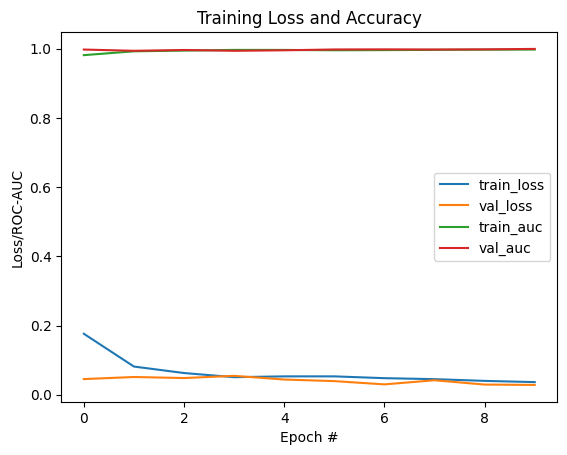

In [ ]:
N = Epochs
# plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["auc"], label="train_auc")
plt.plot(np.arange(0, N), H.history["val_auc"], label="val_auc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/ROC-AUC")
plt.legend(loc="center right")

### Kiểm tra lại mô hình 

**Ảnh chứa gương mặt (1) --> nhận diện gương mặt (2) --> nhận diện có đeo khẩu trăng hoặc không (3) --> Gán nhãn tương ứng (4)**

In [28]:
import cv2
from align_faces import warp_and_crop_face, get_reference_facial_points
from mtcnn.detector import MtcnnDetector
from tensorflow.keras.models import load_model

- Sử dụng hàm nhận diện gương mặt có sẵn đã được cung cấp để tiến hành Face Detection và Face Alignment trước khi nhận diện khẩu trang.


- Face Alignment giúp khuôn mặt dù có bị quay ngang, bị chéo mặt hay thậm chị bị mất nhiều chi tiết do điều kiện ngoại cảnh, lệch ra khỏi khung hình... cũng có thể "căn chỉnh" lại về trung tâm bức ảnh với hướng mặt thẳng chính giữa như mong muốn được. Sau bước detection thì các khuôn mặt của chúng ta có thể ở các trạng thái khác nhau hoặc các góc độ khác nhau, có những khuôn mặt bị chéo và cũng có thể bị lệch do bước detect chưa chính xác trong việc lấy ra khung hình chuẩn của mặt. Thì việc áp dụng Face Alignment ở đây là cần thiết, nó có thể hiểu như một hình thức của data normalization (chuẩn hóa dữ liệu), giúp tiêu chuẩn hoá lại dữ liệu trước khi đưa vào mô hình phân loại (binary classcification), điều này giúp cho mô hình có kết quả dự đoán chính xác hơn.

In [29]:
detector =MtcnnDetector()

def face_detection(img,output_size,align=False):
    # Nếu align=True thì thực hiện buowcs căn chỉnh khuôn mặt (Face Alignment)
    face=None
    # Nhận diện khuôn mặt 
    boxes, facial5points = detector.detect_faces(img)

    # Alignment
    if align == True:
        if len(facial5points) != 0:
            facial5points = np.reshape(facial5points[0], (2, 5))

            default_square = True
            inner_padding_factor = 0.25
            outer_padding = (0, 0)

            ## Yêu cầu 10:
            ## VIẾT CODE Ở ĐÂY:

            # sử dụng hàm get_reference_facial_points
            reference_5pts = get_reference_facial_points(
                output_size, inner_padding_factor, outer_padding, default_square)

            # sử dụng hàm warp_and_crop_face
            face = warp_and_crop_face(img, facial5points, reference_pts = reference_5pts, crop_size = output_size)

    # Không Alignment
    else:
        (h,w) = img.shape[:2]
        if len(boxes) != 0:
            for box in boxes:
                (startX, startY, endX, endY) = box[:4].astype('int')
                (startX, startY) = (max(0, startX),max(0, startY))
                (endX, endY) = (min(w-1, endX), min(h-1, endY))
                face = img[startY:endY, startX:endX]
                face = cv2.resize(face, output_size)

    return face

In [30]:
# Tạo ra mảng chứa các ảnh sau khi nhận diện gương mặt 
test_X_align = test_X.copy()

#### Loại bỏ những tấm ảnh ko có gương mặt 

In [31]:
choose = []

for i in range(len(test_X)):
    try:
        # Nhận diện gương mặt kết hợp với Face Alignement, trả về kích thươc ảnh là 224x224
        test_X_align[i] = face_detection(test_X[i].astype('uint8'), (224, 224), align = True)
        # Lưu chỉ mục của ảnh đã nhận diện thành công vào mảng choose
        choose.append(i)
    except:
        # Nếu tấm ảnh không nhận diện được bỏ qua tấm này
        continue

choose = np.array(choose)

In [32]:
test_X_align.shape

(3200, 224, 224, 3)

In [33]:
choose=choose.astype(int)
test_X_align[choose, :, :, :].shape

(3129, 224, 224, 3)

#### Đánh giá mô hình bằng chỉ số ROC-AUC

In [ ]:
from sklearn.metrics import roc_auc_score
# 1. Lọc dữ liệu và Dự đoán (Lấy ra xác suất)
predict = model.predict(test_X_align[choose])

# 2. Chuẩn bị Nhãn thật
true_labels = np.argmax(test_Y[choose], axis=1)

# 3. Tính ROC-AUC
roc_value = roc_auc_score(true_labels, predict[:, 1])

print("ROC-AUC: ", roc_value)

55/55 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step
ROC-AUC:  0.9862566650120891


### Nhận diện nhiều khuôn mặt (Multi-Faces)

In [34]:
from tensorflow.keras.models import load_model
from mtcnn.detector import MtcnnDetector

# 1. Khởi tạo công cụ tìm mặt 
detector = MtcnnDetector()

# 2. Tải mô hình đã huấn luyện
model = load_model('efficientnet.keras')
print("Load model thành công!")

Load model thành công!


### Xây dựng hàm test 


In [36]:
def mask_detect(image):

    img = image.copy()
    (h,w) = img.shape[:2] # Lấy chiều cao và chiều rộng của ảnh
    boxes, facial5points = detector.detect_faces(img) #Dùng MTCNN để tìm tất cả khuôn mặt
    for box in boxes:
        #Lây các tọa độ của hộp bao quanh khuôn mặt
        (startX,startY,endX,endY)=box[:4].astype('int')

        (startX,startY)=(max(0,startX),max(0,startY))
        (endX,endY)=(min(w-1,endX), min(h-1,endY))


        # Cắt phần khuôn mặt từ ảnh gốc, thay đổi kích thước về 224x224
        face=img[startY:endY, startX:endX]
        face=cv2.resize(face,(224,224))

        #dự đoán xem có đeo khẩu trang hay không
        (mask,withoutMask)=model.predict(face.reshape(1,224,224,3))[0]

        # So sánh xác suất: Nếu mask > withoutMask thì là "Mask" (Đeo khẩu trang)
        label='Mask' if mask>withoutMask else 'No Mask'
        color=(0,255,0) if label=='Mask' else (0,0,255)

        #Thêm độ tin cậy vào nhãn (Ví dụ: Mask: 99.50%)
        label="{}: {:.2f}%".format(label,max(mask,withoutMask)*100)

        # Vẽ chữ và vẽ khung lên ảnh
        cv2.putText(img,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        cv2.rectangle(img,(startX,startY),(endX,endY),color,2)

    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


QFontDatabase: Cannot find font directory /home/hoang/.local/share/mamba/envs/MLP306/lib/python3.10/site-packages/cv2/qt/fonts.
Note that Qt no longer ships fonts. Deploy some (from https://dejavu-fonts.github.io/ for example) or switch to fontconfig.
QFontDatabase: Cannot find font directory /home/hoang/.local/share/mamba/envs/MLP306/lib/python3.10/site-packages/cv2/qt/fonts.
Note that Qt no longer ships fonts. Deploy some (from https://dejavu-fonts.github.io/ for example) or switch to fontconfig.
QFontDatabase: Cannot find font directory /home/hoang/.local/share/mamba/envs/MLP306/lib/python3.10/site-packages/cv2/qt/fonts.
Note that Qt no longer ships fonts. Deploy some (from https://dejavu-fonts.github.io/ for example) or switch to fontconfig.
QFontDatabase: Cannot find font directory /home/hoang/.local/share/mamba/envs/MLP306/lib/python3.10/site-packages/cv2/qt/fonts.
Note that Qt no longer ships fonts. Deploy some (from https://dejavu-fonts.github.io/ for example) or switch to font

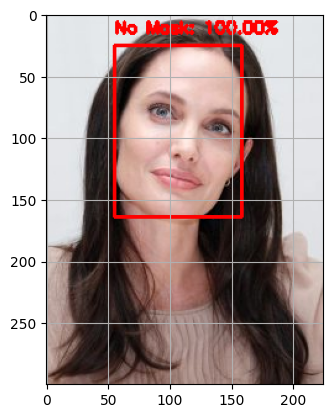

In [ ]:
img = cv2.imread("image/angelina.jpg")
img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


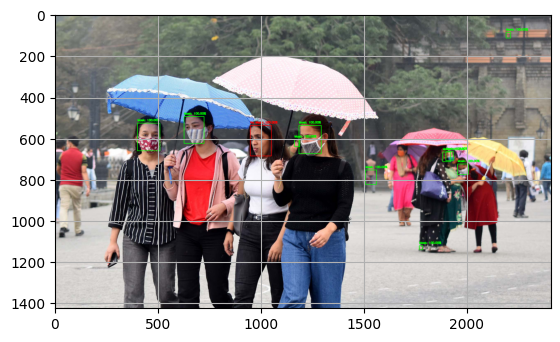

In [ ]:
img = cv2.imread("image/woman.jpg")
img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


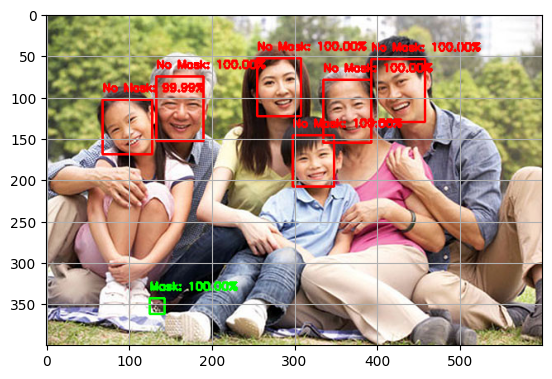

In [ ]:
img = cv2.imread("image/family.jpg")
img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Thêm phần chức năng nhận diện bằng video 

In [ ]:
import cv2
import numpy as np

# 1. Mở camera
vs = cv2.VideoCapture(0)

print("Đang mở camera... Nhấn 'q' để thoát.")

while True:
    # 2. Đọc frame từ camera
    ret, frame = vs.read()
    
    # Kiểm tra nếu đọc lỗi (hoặc camera chưa bật kịp)
    if not ret:
        continue

    # --- ĐOẠN SỬA LỖI QUAN TRỌNG ---
    try:
        # Thử tìm khuôn mặt. Nếu không có mặt, hàm này sẽ gây lỗi ValueError
        boxes, facial5points = detector.detect_faces(frame)
    except ValueError:
        # Nếu lỗi (do không thấy mặt), ta bỏ qua frame này và tiếp tục vòng lặp
        boxes = [] # Gán rỗng để code phía dưới không chạy
        pass
    except Exception as e:
        # Bắt các lỗi khác cho chắc ăn
        print(f"Lỗi lạ: {e}")
        boxes = []

    # 3. Vẽ khung (Chỉ chạy khi tìm thấy mặt - tức là boxes không rỗng)
    if len(boxes) > 0:
        for box in boxes:
            (startX, startY, endX, endY) = box[:4].astype('int')
            
            # Xử lý biên ảnh
            (h, w) = frame.shape[:2]
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w-1, endX), min(h-1, endY))

            # Cắt mặt và dự đoán
            try:
                face = frame[startY:endY, startX:endX]
                
                # --- NHỚ CHUYỂN MÀU BGR -> RGB ---
                face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                face = cv2.resize(face, (224, 224))
                
                # Reshape và Predict
                (mask, withoutMask) = model.predict(face.reshape(1, 224, 224, 3))[0]

                # Vẽ
                label = 'Mask' if mask > withoutMask else 'No Mask'
                color = (0, 255, 0) if label == 'Mask' else (0, 0, 255)
                label = "{}: {:.2f}%".format(label, max(mask, withoutMask)*100)

                cv2.putText(frame, label, (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
                cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
            except Exception as e:
                pass # Bỏ qua nếu cắt mặt bị lỗi

    # 4. Hiển thị
    cv2.imshow("Frame", frame)
    
    # Bấm 'q' để thoát
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

# Dọn dẹp
vs.release()
cv2.destroyAllWindows()

Đang mở camera... Nhấn 'q' để thoát.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


QFontDatabase: Cannot find font directory /home/hoang/.local/share/mamba/envs/MLP306/lib/python3.10/site-packages/cv2/qt/fonts.
Note that Qt no longer ships fonts. Deploy some (from https://dejavu-fonts.github.io/ for example) or switch to fontconfig.
QFontDatabase: Cannot find font directory /home/hoang/.local/share/mamba/envs/MLP306/lib/python3.10/site-packages/cv2/qt/fonts.
Note that Qt no longer ships fonts. Deploy some (from https://dejavu-fonts.github.io/ for example) or switch to fontconfig.
QFontDatabase: Cannot find font directory /home/hoang/.local/share/mamba/envs/MLP306/lib/python3.10/site-packages/cv2/qt/fonts.
Note that Qt no longer ships fonts. Deploy some (from https://dejavu-fonts.github.io/ for example) or switch to fontconfig.
QFontDatabase: Cannot find font directory /home/hoang/.local/share/mamba/envs/MLP306/lib/python3.10/site-packages/cv2/qt/fonts.
Note that Qt no longer ships fonts. Deploy some (from https://dejavu-fonts.github.io/ for example) or switch to font

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━

### Cải thiện mô hình 

#### Khởi tạo 

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
    rotation_range=25,       # Xoay ảnh nhiều hơn
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2], # Thêm chỉnh độ sáng
    fill_mode="nearest"
)

#### Sử dụng model Fine-tunning EfficientNetB3

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Input
baseModel = tf.keras.applications.EfficientNetB3(
    weights="imagenet", 
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3))
)
# Đóng băng toàn bộ lúc đầu
baseModel.trainable = False 

In [39]:
baseModel.summary()

Model: "efficientnetb3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 10,783,535 (41.14 MB)

In [40]:
# Xây dựng Head mới
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel) # Tăng số node lên 256
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

In [41]:
for layer in baseModel.layers:
    layer.trainable =False

In [42]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 11,177,521 (42.64 MB)

 Trainable params: 393,986 (1.50 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
learning_rate = 0.001
Epochs = 10
BS = 40
# label_smoothing=0.1 nghĩa là: 
# Nhãn 1 (Mask) sẽ được coi là 0.9
# Nhãn 0 (No Mask) sẽ được coi là 0.1
loss_fn = BinaryCrossentropy(label_smoothing=0.1)
opt = Adam(learning_rate = learning_rate, decay = learning_rate/Epochs)

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 1. Tự động giảm LR nếu loss không giảm sau 3 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,    # Giảm 5 lần (chia 0.2)
    patience=3,    # Đợi 3 epoch
    min_lr=1e-6,   # Không giảm quá mức này
    verbose=1
)

# 2. Dừng sớm nếu train mãi không khá hơn (tránh lãng phí điện)
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True # Quan trọng: Khôi phục lại bộ weight tốt nhất từng đạt được
)
model.compile(loss=loss_fn, optimizer = opt, metrics = [tf.keras.metrics.AUC(name='auc')],run_eagerly=True)

# Thêm vào model.fit
H = model.fit(
    aug.flow(train_X, train_Y, batch_size = BS),
    steps_per_epoch = len(train_X)//BS,
    validation_data = (val_X, val_Y),
    validation_steps = len(val_X)//BS,
    epochs = Epochs,
    callbacks=[reduce_lr, early_stop]
)
model.save('efficientnetb3.keras')



Epoch 1/10
 22/100 ━━━━━━━━━━━━━━━━━━━━ 31:03:56 1434s/step - auc: 0.9415 - loss: 0.4109